# Tutorial Notebook
## Import PLUME object from models.py

In [ ]:
import sys
sys.path.append('/Users/Malachite/Documents/UW/ARA/ARA-Plumes/')
from models import PLUME

## Instantiate PLUME object

Videos can be found on Doppio in `home/ara/data/plume_videos` directory

We will work with the low velocity video `low_2.MP4` taken on July 20th, 2023.

In [ ]:
# specify path to video (Example videos can be found on Doppio)
video_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/plume_videos/July_20/video_low_2/low_2.MP4"
plume_learner = PLUME(video_path=video_path)

### Declare $(x,y)$ leak source of plume
helper functions `VideoPointPicker` & `ImagePointPicker` from `utils.py` can be used to find original leak source. 

Example code can be found in `test_functions/get_center.py`

In [ ]:
plume_leak_source = (1588, 1017)
plume_learner.orig_center = plume_leak_source

### Declare `fixed_range` for background subtraction and `img_range` to apply concentric circle method

In [ ]:
# Seconds until plume start
seconds = 4

# Frames until plume starts (used to create background image to apply fixed subtraction method)
fps= plume_learner.fps
fixed_range = seconds*fps

# Image range to apply concentric circle method 
img_range=[fixed_range+220,10*plume_learner.fps]

## Apply Concentric Circle method
*can take a little while to run*

In [ ]:
save_path = "gauss_time_blur"

gauss_space_blur = True
gauss_kernel_size = 251
gauss_space_sigma = 105

gauss_time_blur = True
gauss_time_window = 5
gauss_time_sigma =0.5


mean_smoothing = True
mean_smoothing_sigma = 3

plume_learner.train(img_range=img_range,
                    fixed_range=fixed_range,
                    gauss_space_blur=gauss_space_blur,
                    gauss_kernel_size=gauss_kernel_size,
                    gauss_space_sigma=gauss_space_sigma,
                    gauss_time_blur=gauss_time_blur,
                    gauss_time_window=gauss_time_window,
                    gauss_time_sigma=gauss_time_sigma,
                    mean_smoothing=mean_smoothing,
                    mean_smoothing_sigma=mean_smoothing_sigma,
                    save_path=save_path)

# Save arrays to pickle File

In [2]:
import pickle

### Save poly coeff from plume_learner

In [ ]:
arrays_dict = {}
arrays_dict["mean"] = plume_learner.mean_poly
arrays_dict["var1"] = plume_learner.var1_poly
arrays_dict["var2"] = plume_learner.var2_poly

pickle_name ="gauss_blur_coeff.pkl"

with open(pickle_name, 'wb') as f:
    pickle.dump(arrays_dict,f)

### Load poly coeff from pickle file

In [3]:
pickle_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/tutorial/gauss_blur_coeff.pkl"

with open(pickle_path, 'rb') as f:
    loaded_arrays = pickle.load(f)

mean_array = loaded_arrays["mean"]
var1_array = loaded_arrays["var1"]
var2_array = loaded_arrays["var2"]

# Apply ensemble SINDy

In [4]:
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [25]:
t = np.array([i for i in range(len(mean_array))])
scalar = StandardScaler()
normalized_mean_array = scalar.fit_transform(mean_array)

thresh = 0.5
feature_names = ['a', 'b', 'c']
smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws = {'window_length': 5})

ensemble_optimizer = ps.STLSQ(threshold=thresh, alpha = 1e-3, max_iter=200)
model = ps.SINDy(feature_names=feature_names,
                optimizer=ensemble_optimizer,
                differentiation_method=smoothed_fd)
model.fit(normalized_mean_array,t=t, ensemble=True,quiet=True)
model.print()

(a)' = -1.220 a + -1.883 b + -0.691 c
(b)' = 1.174 a + 1.799 b + 0.658 c
(c)' = -1.048 a + -1.590 b + -0.578 c


### plot normalized coefficients and learned derivatives

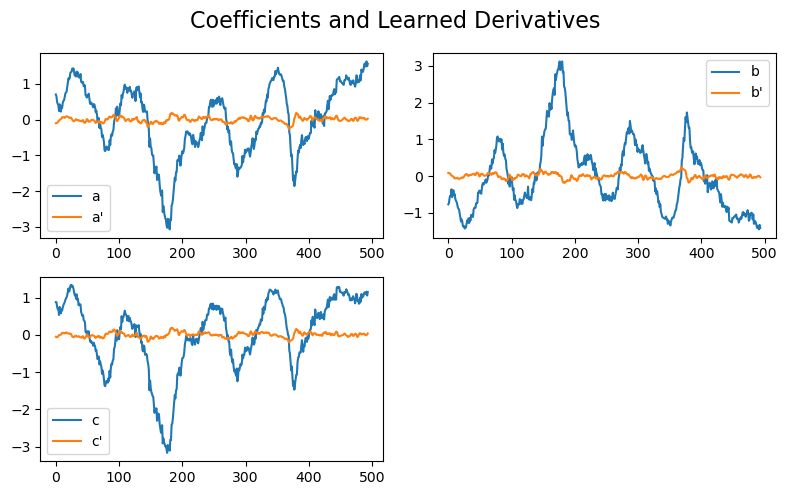

In [22]:
smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 8})

x_dot = smoothed_fd._differentiate(normalized_mean_array, t)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plot the first set of data (a and a') in the first subplot
axs[0, 0].plot(t, normalized_mean_array[:,0], label="a")
axs[0, 0].plot(t, x_dot[:,0], label="a'")
axs[0, 0].legend()

# Plot the second set of data (b and b') in the second subplot
axs[0, 1].plot(t, normalized_mean_array[:,1], label="b")
axs[0, 1].plot(t, x_dot[:,1], label="b'")
axs[0, 1].legend()

# Plot the third set of data (c and c') in the third subplot
axs[1, 0].plot(t, normalized_mean_array[:,2], label="c")
axs[1, 0].plot(t, x_dot[:,2], label="c'")
axs[1, 0].legend()

# Hide the empty fourth subplot
axs[1, 1].axis('off')

fig.suptitle('Coefficients and Learned Derivatives', fontsize=16)

# Adjust layout and display the subplot
plt.tight_layout()
plt.show()

### Solve normalized ODE system

In [26]:
X_train = normalized_mean_array
t_train = t
x0 = X_train[0]

X_train_sim = model.simulate(x0,t_train)

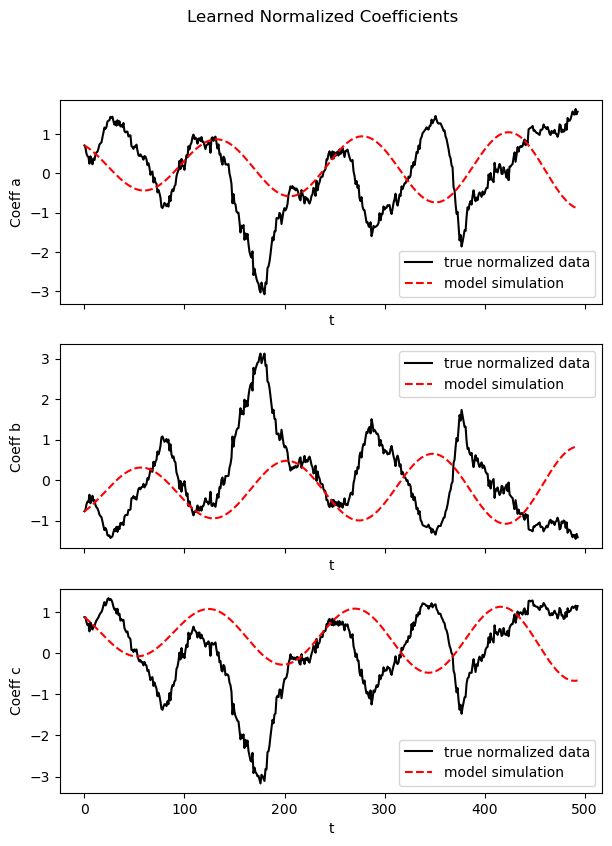

In [27]:
m = min(X_train.shape[0],X_train_sim.shape[0])

fig, axs = plt.subplots(X_train.shape[1], 1, sharex=True, figsize=(7, 9))
fig.suptitle("Learned Normalized Coefficients")  # Add this line to set the title

for i in range(X_train.shape[1]):
    axs[i].plot(t_train[:m], X_train[:m, i], "k", label="true normalized data")
    axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--", label="model simulation")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel="Coeff {}".format(feature_names[i]))
fig.show()